## HIERARCHICAL FUNCTION CALLING AGENT FOR OPENBB

In [ ]:
!git clone https://github.com/Athe-kunal/openbb-agent.git

In [ ]:
import os

os.chdir("openbb-agent")

## PROVIDE YOUR OPENAI API KEY AND OPENBB PERSONAL ACCESS TOKEN (PAT)

You can fill in your API keys from different financial providers in OpenBB by logging into your OpenBB platform and filling in the API keys for each provider. Then you can generate a PAT token to login to OpenBB

In [ ]:
%%writefile .env
OPENAI_API_KEY=""
OBB_PAT=""

In [1]:
from agent.dspy_obb_agent import DSPYOpenBBAgent
from dotenv import load_dotenv,find_dotenv
from agent.database import load_database, build_database, build_docs_metadata
from agent.dspy_agent import OpenBBAgentChroma
import os 

%load_ext autoreload
%autoreload 2

load_dotenv(find_dotenv(),override=True)

True

## BUILDING THE DATABASE

In [2]:
from agent.database import build_graph

router_names_graph,router_names = build_graph()

## REASONING BEHIND HIERARCHICAL FUNCTION CALLING

1. Function discovery or relevant tool discovery is essential in function calling. The current method includes similarity matching with the function descriptions and picking 3-4 functions.
2. But in hierarchical function calling, we can divide the functions into hierarchical graphs, as you can view below. Each graph has a parent node and the leaf nodes are the functions from different providers in OpenBB
3. We can traverse the graph by passing the descriptions of the current level nodes, and use an LLM to pick the node to jump to. Hence, we can narrow down the search space of these functions and break down the problem

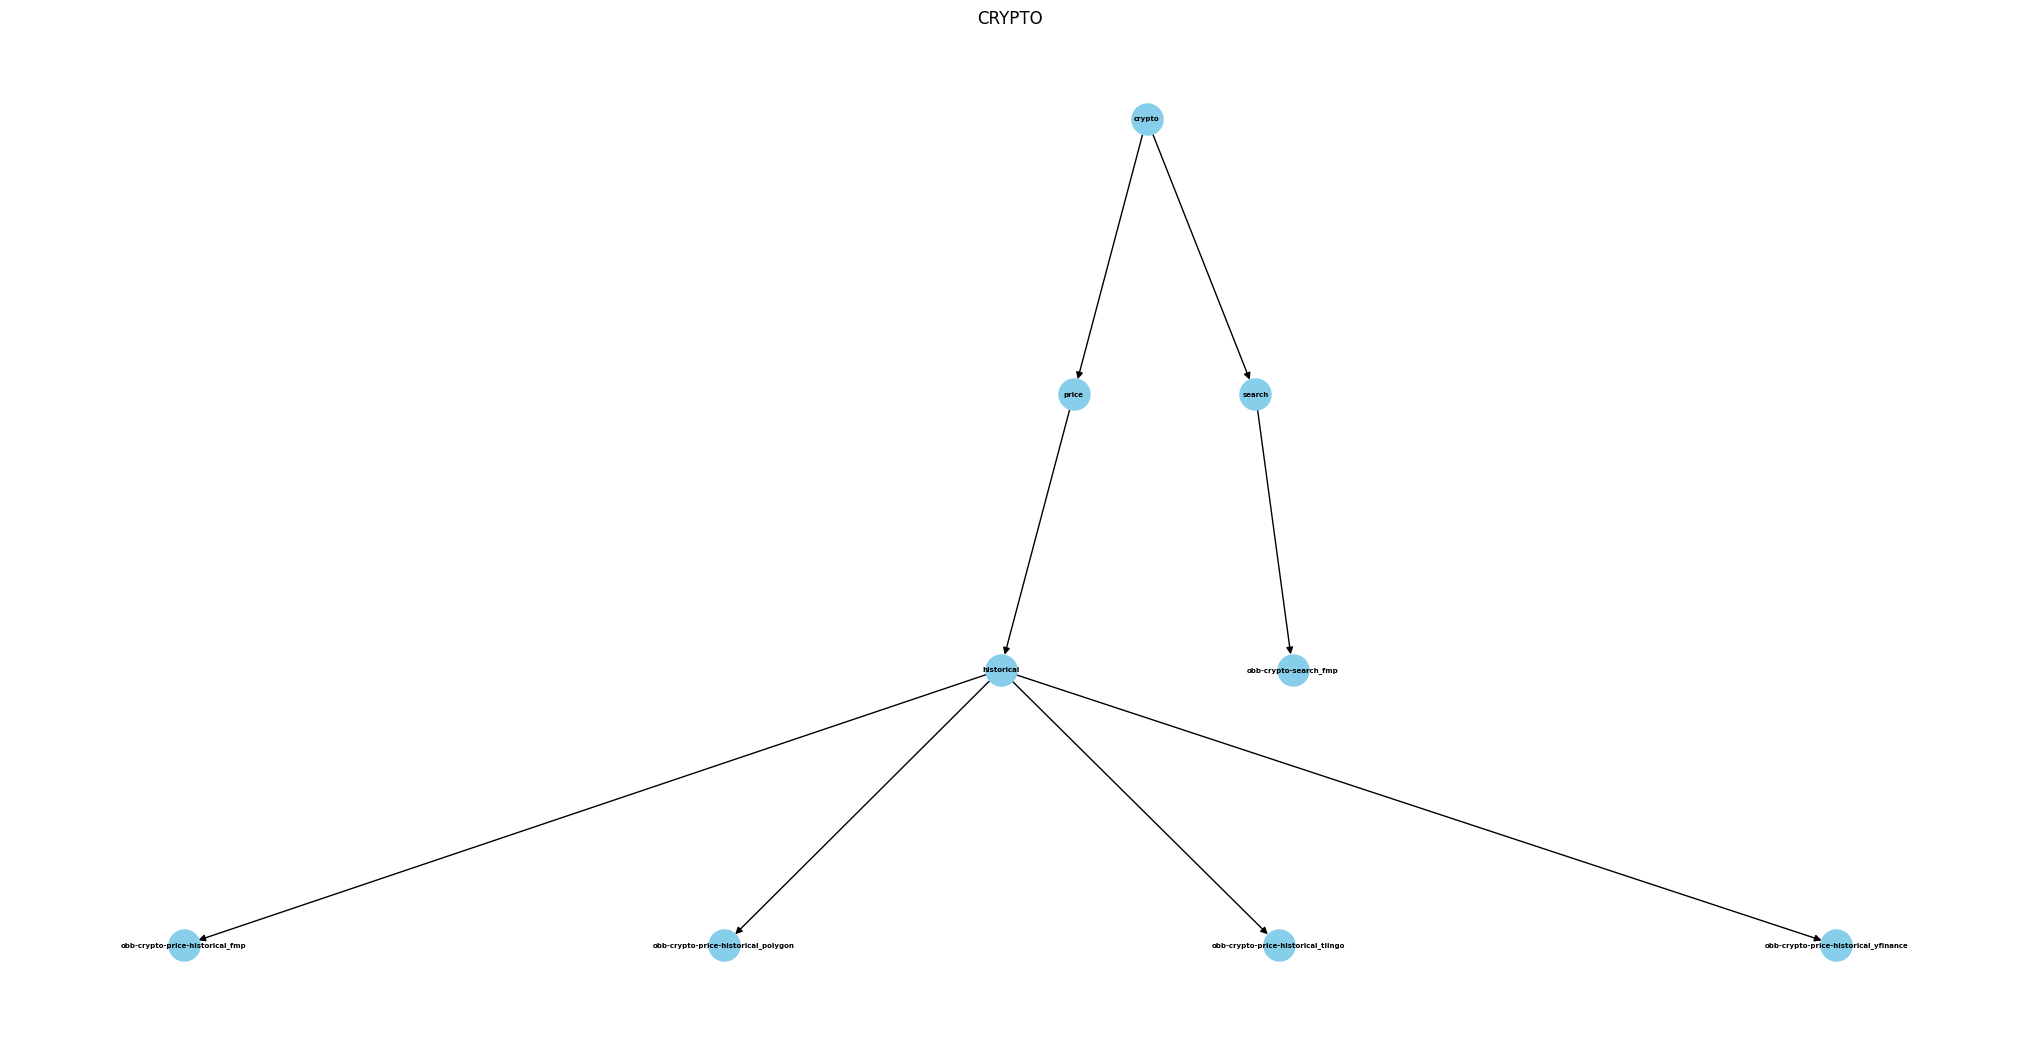

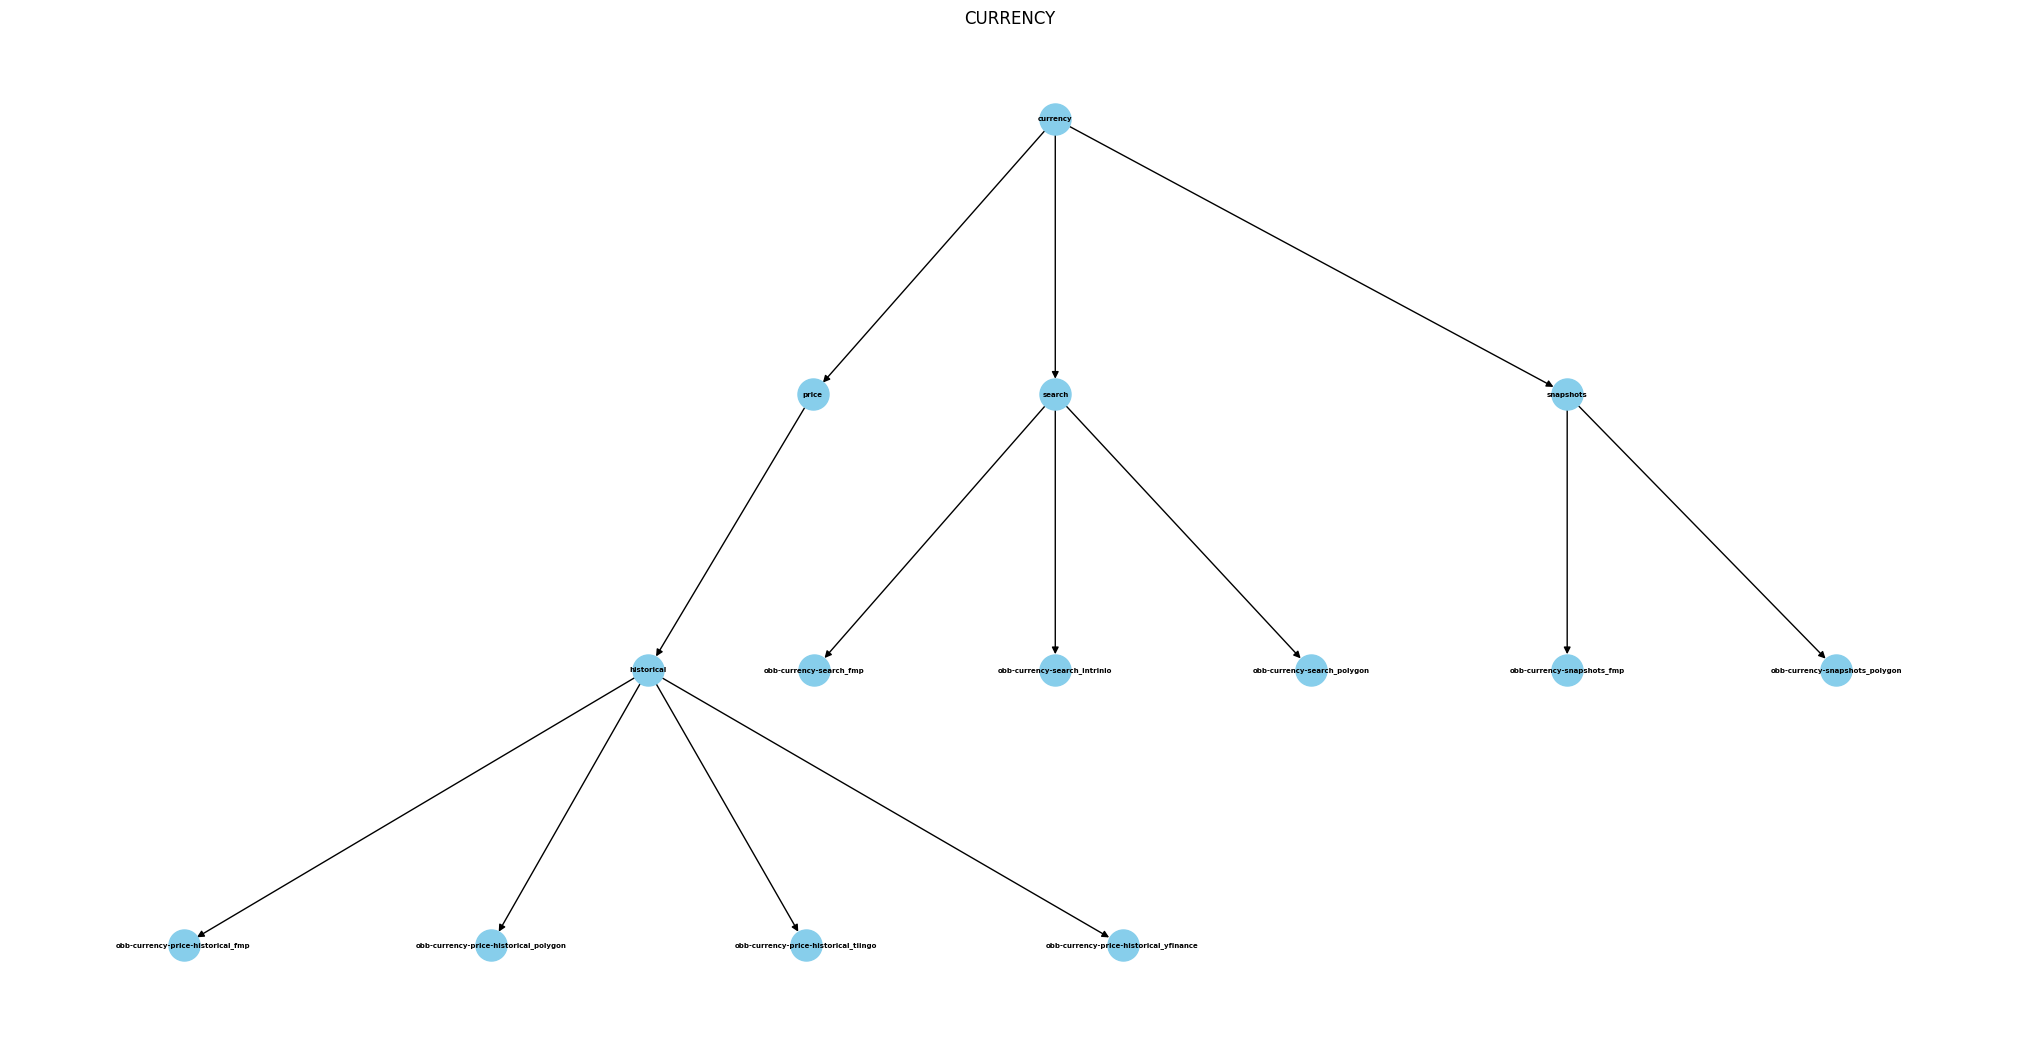

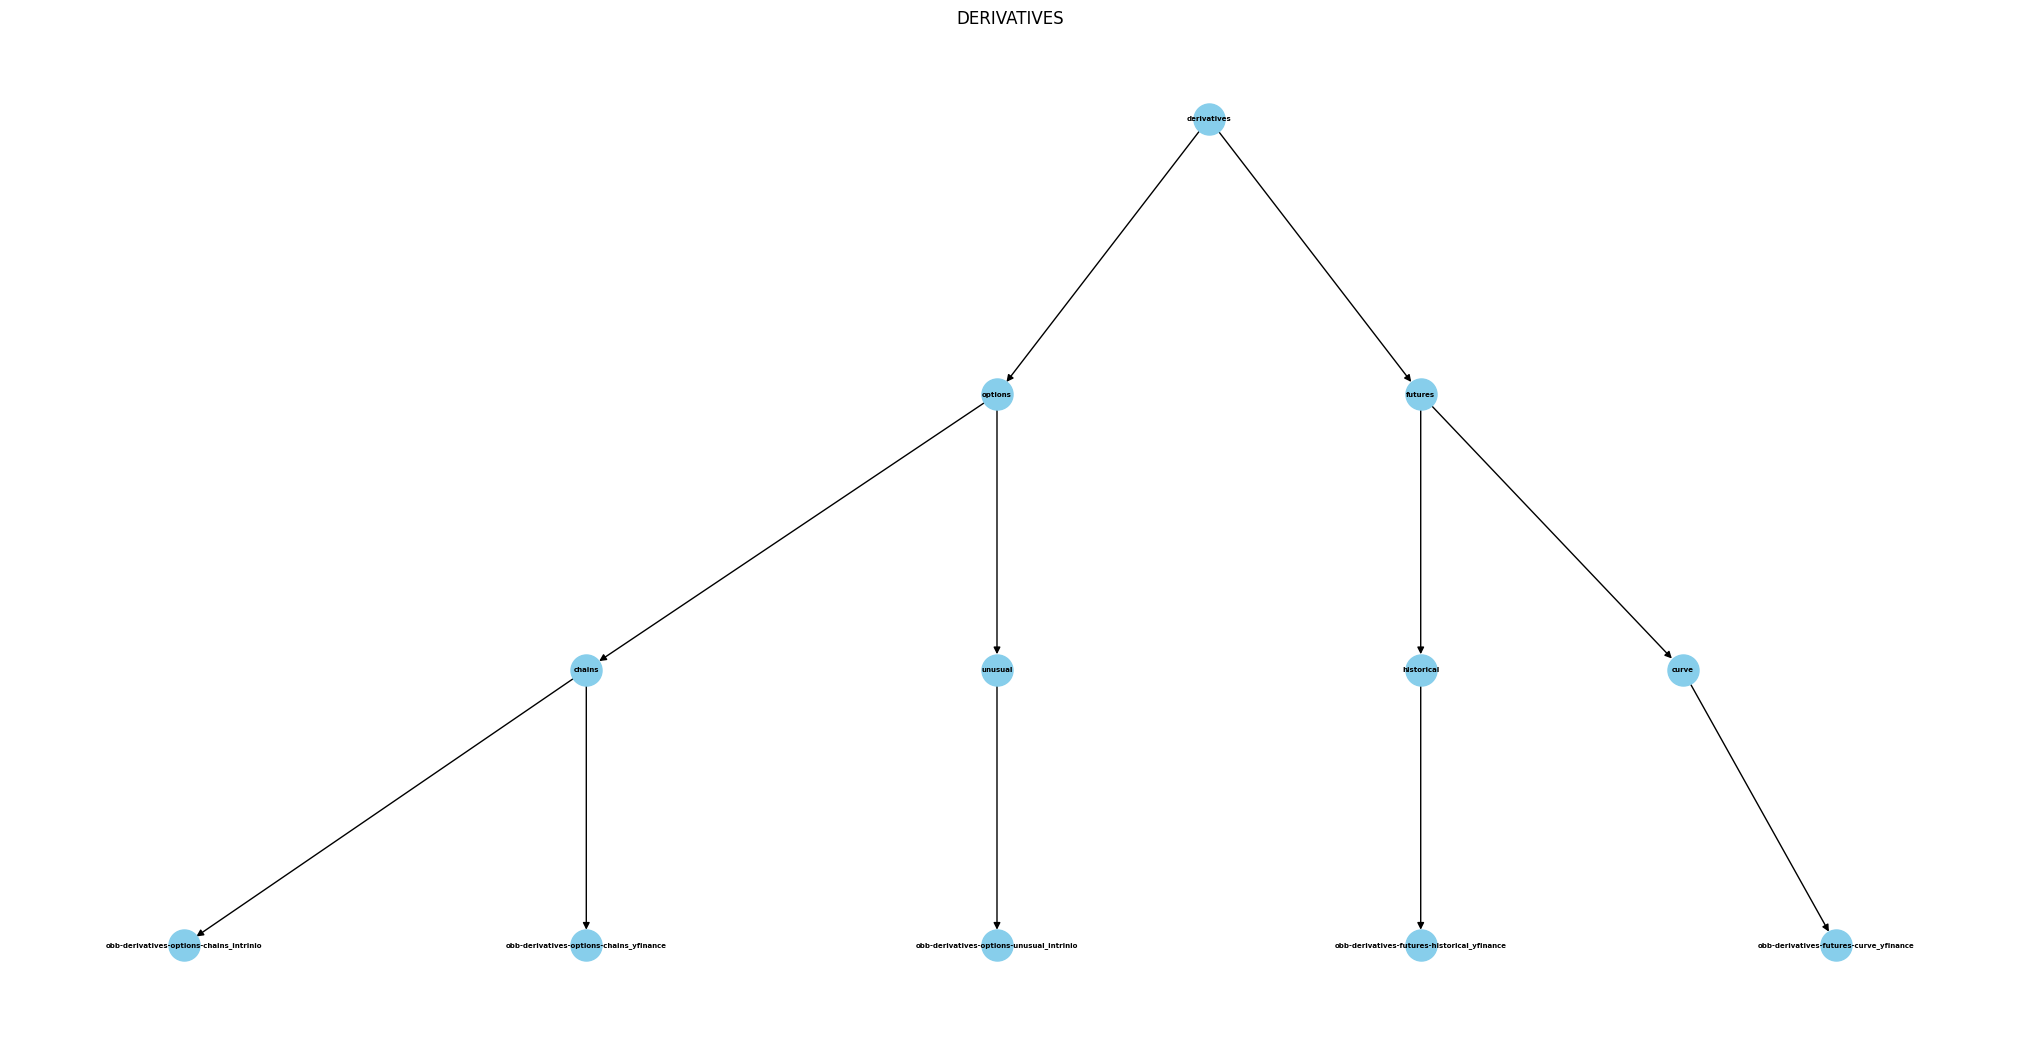

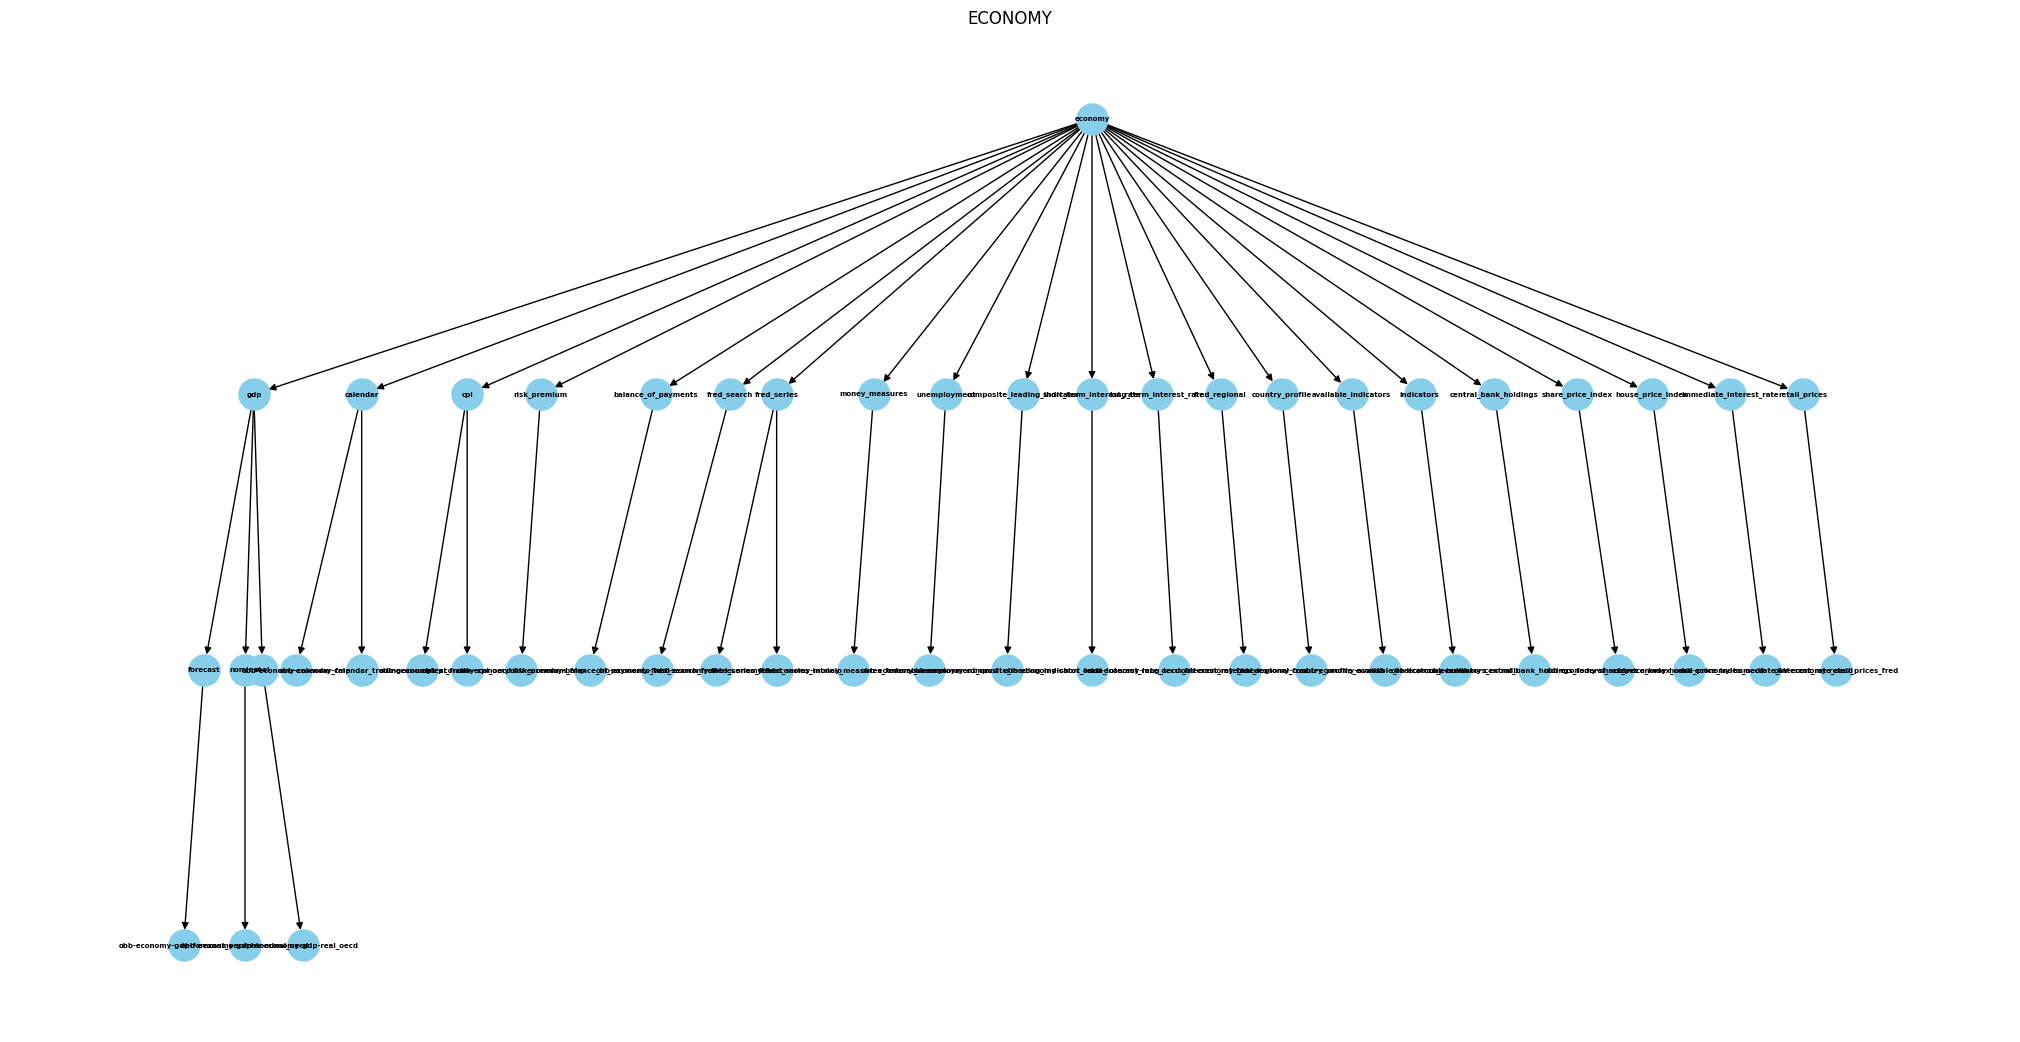

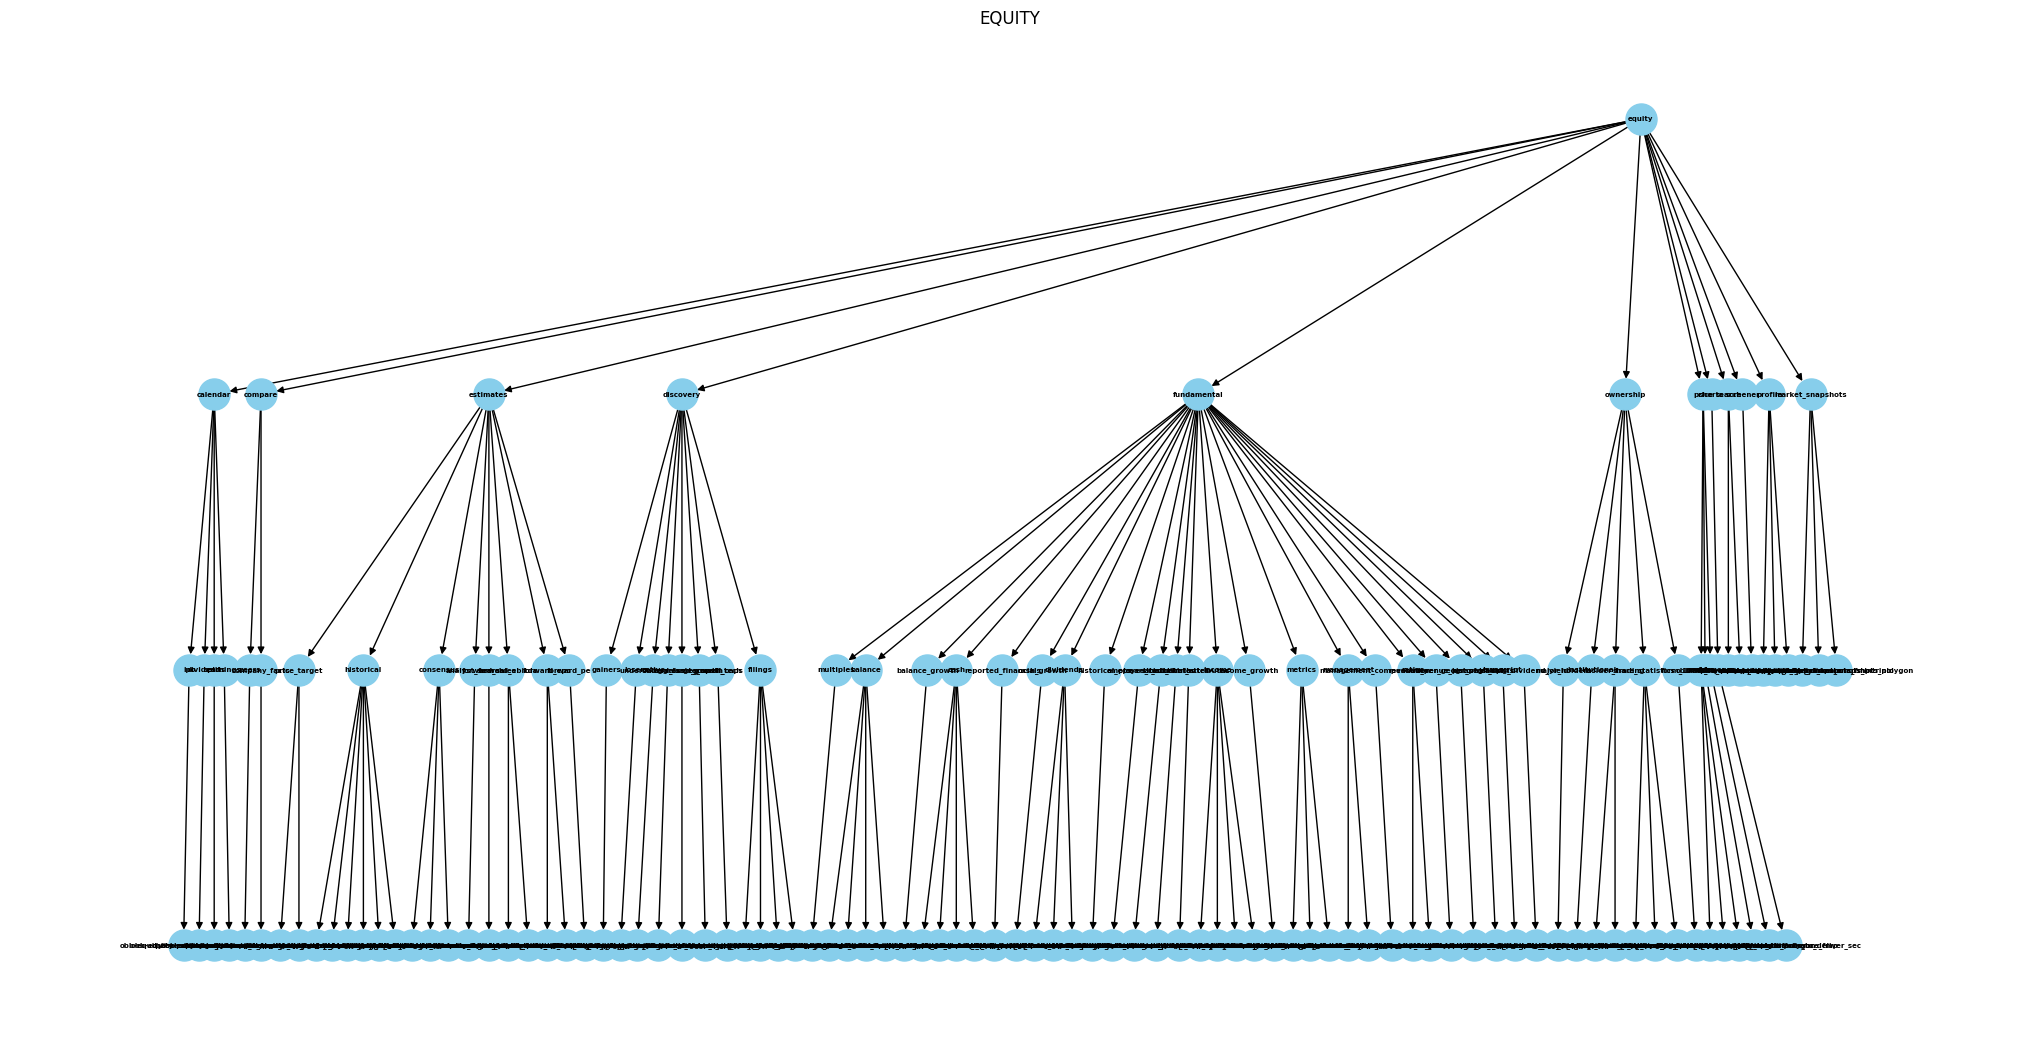

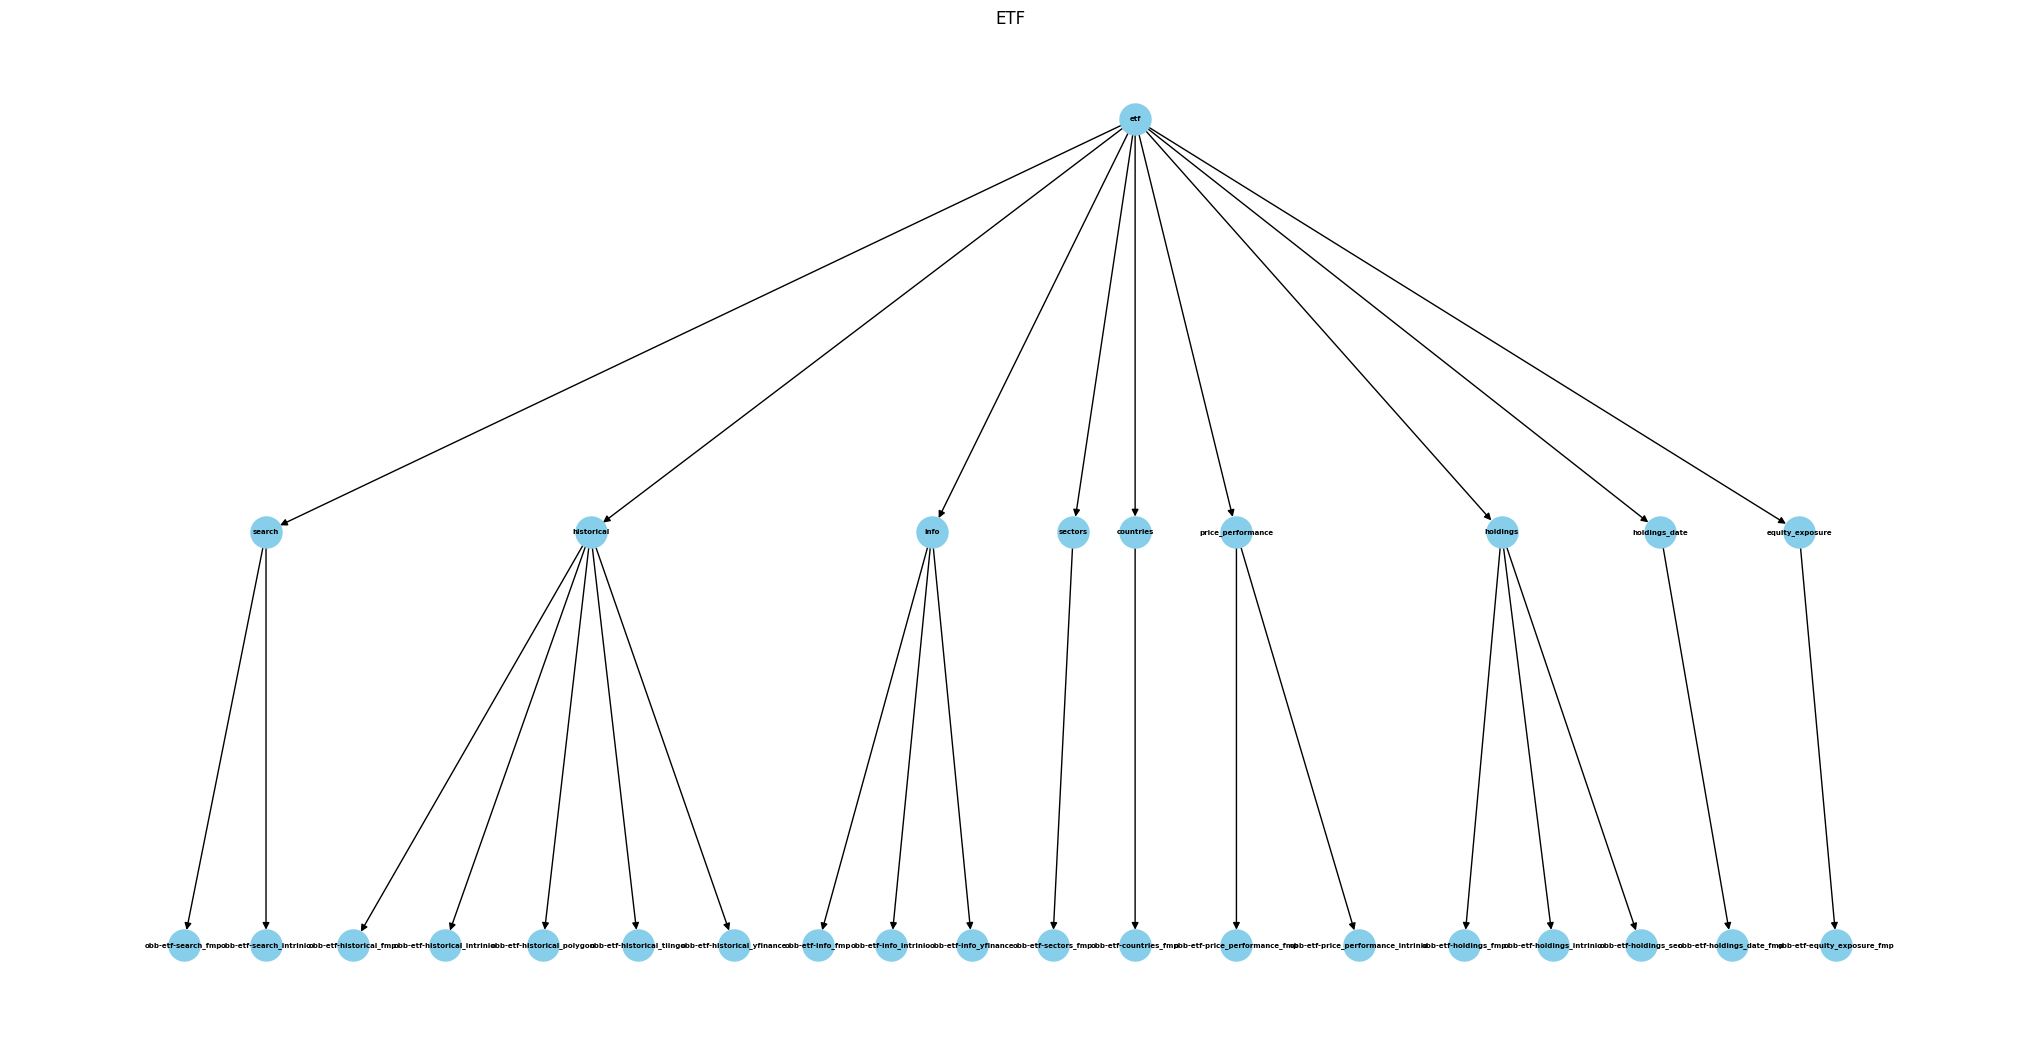

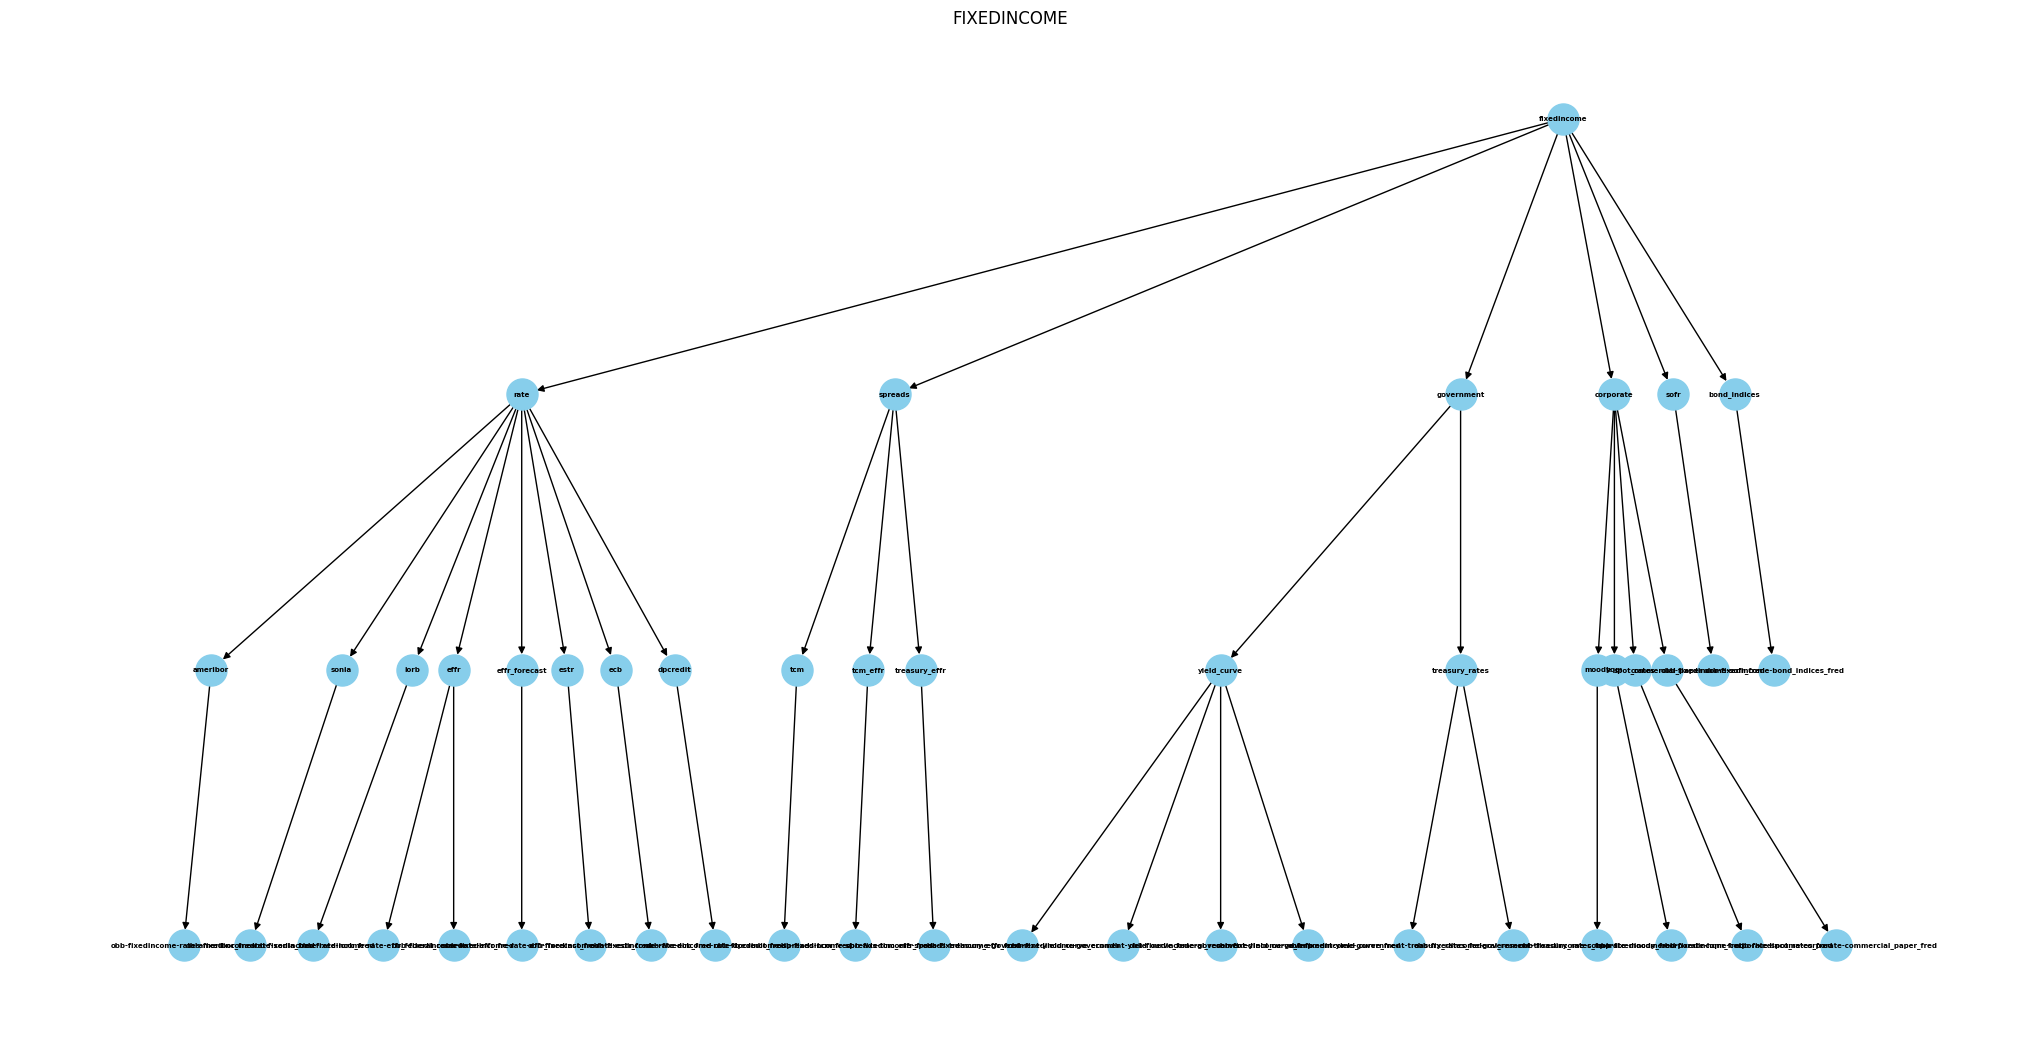

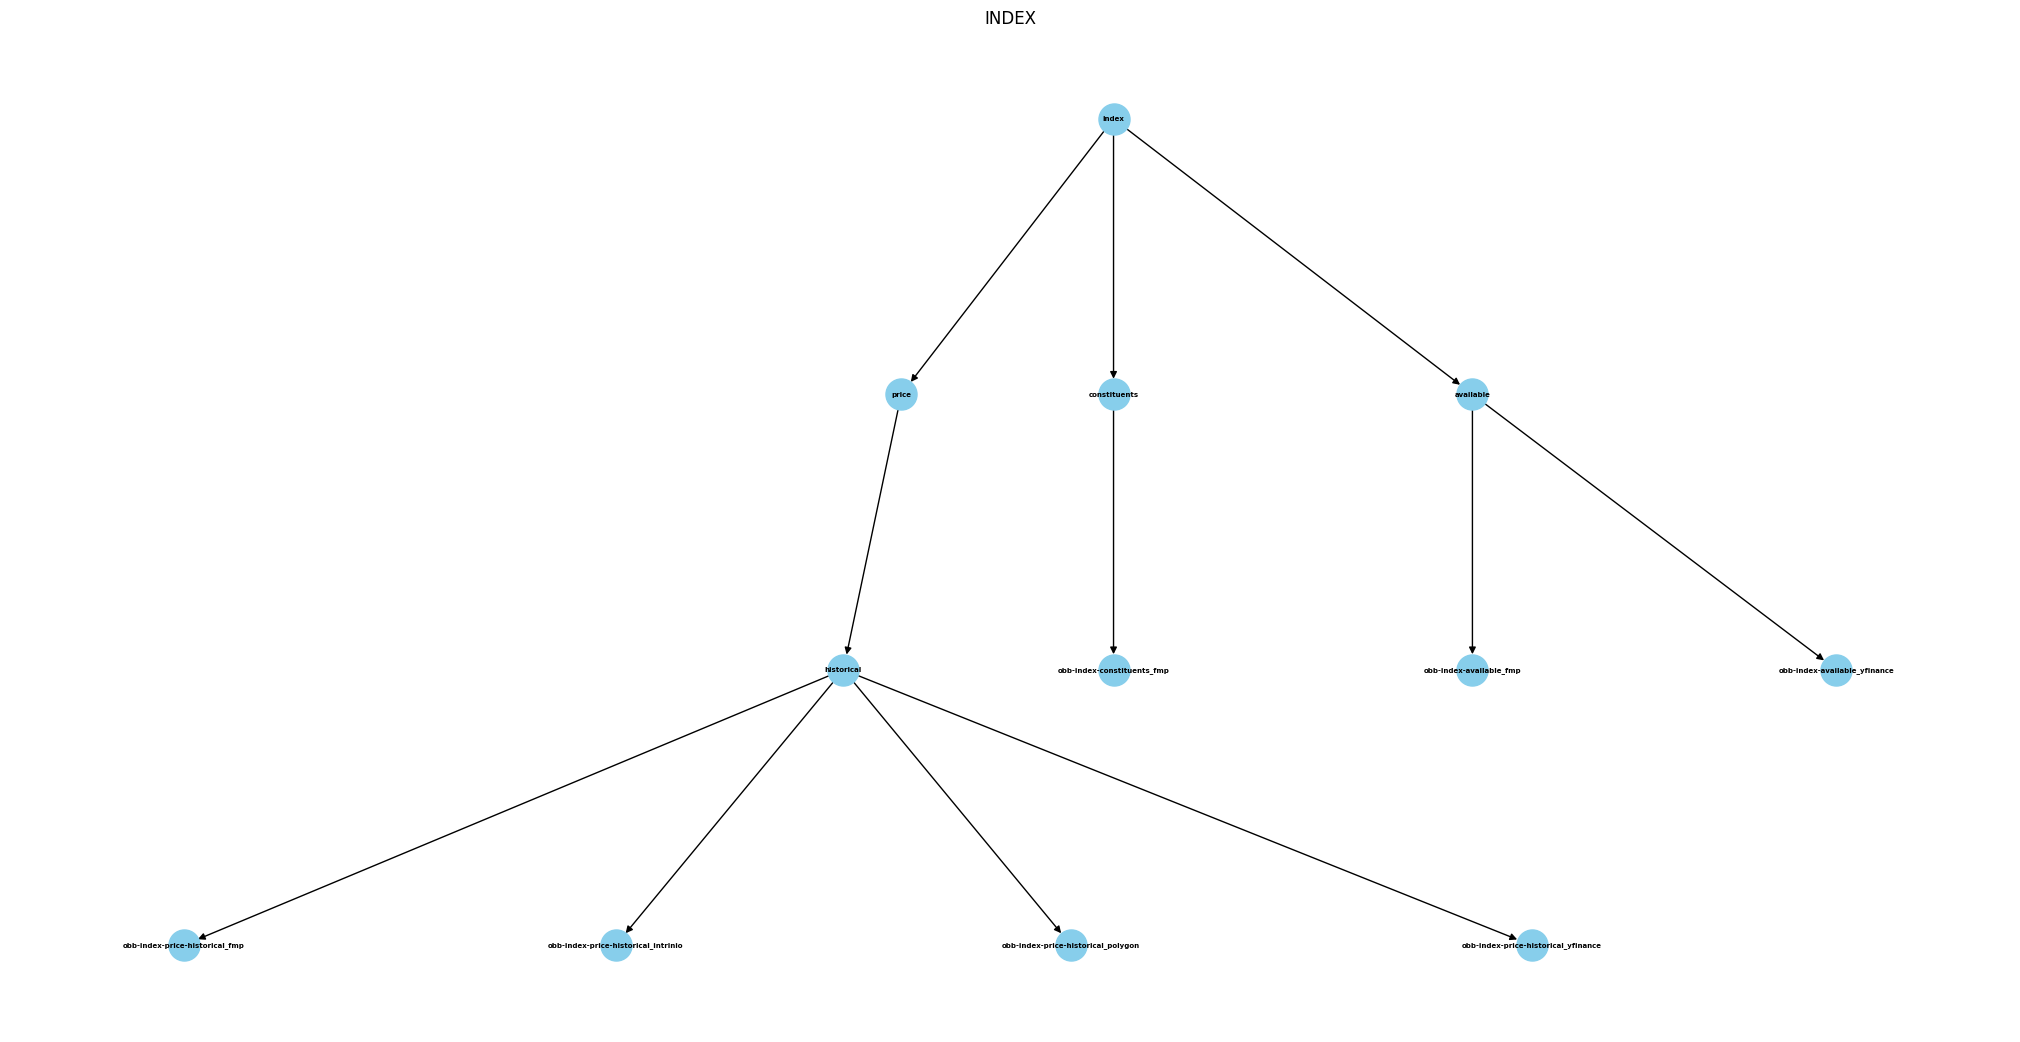

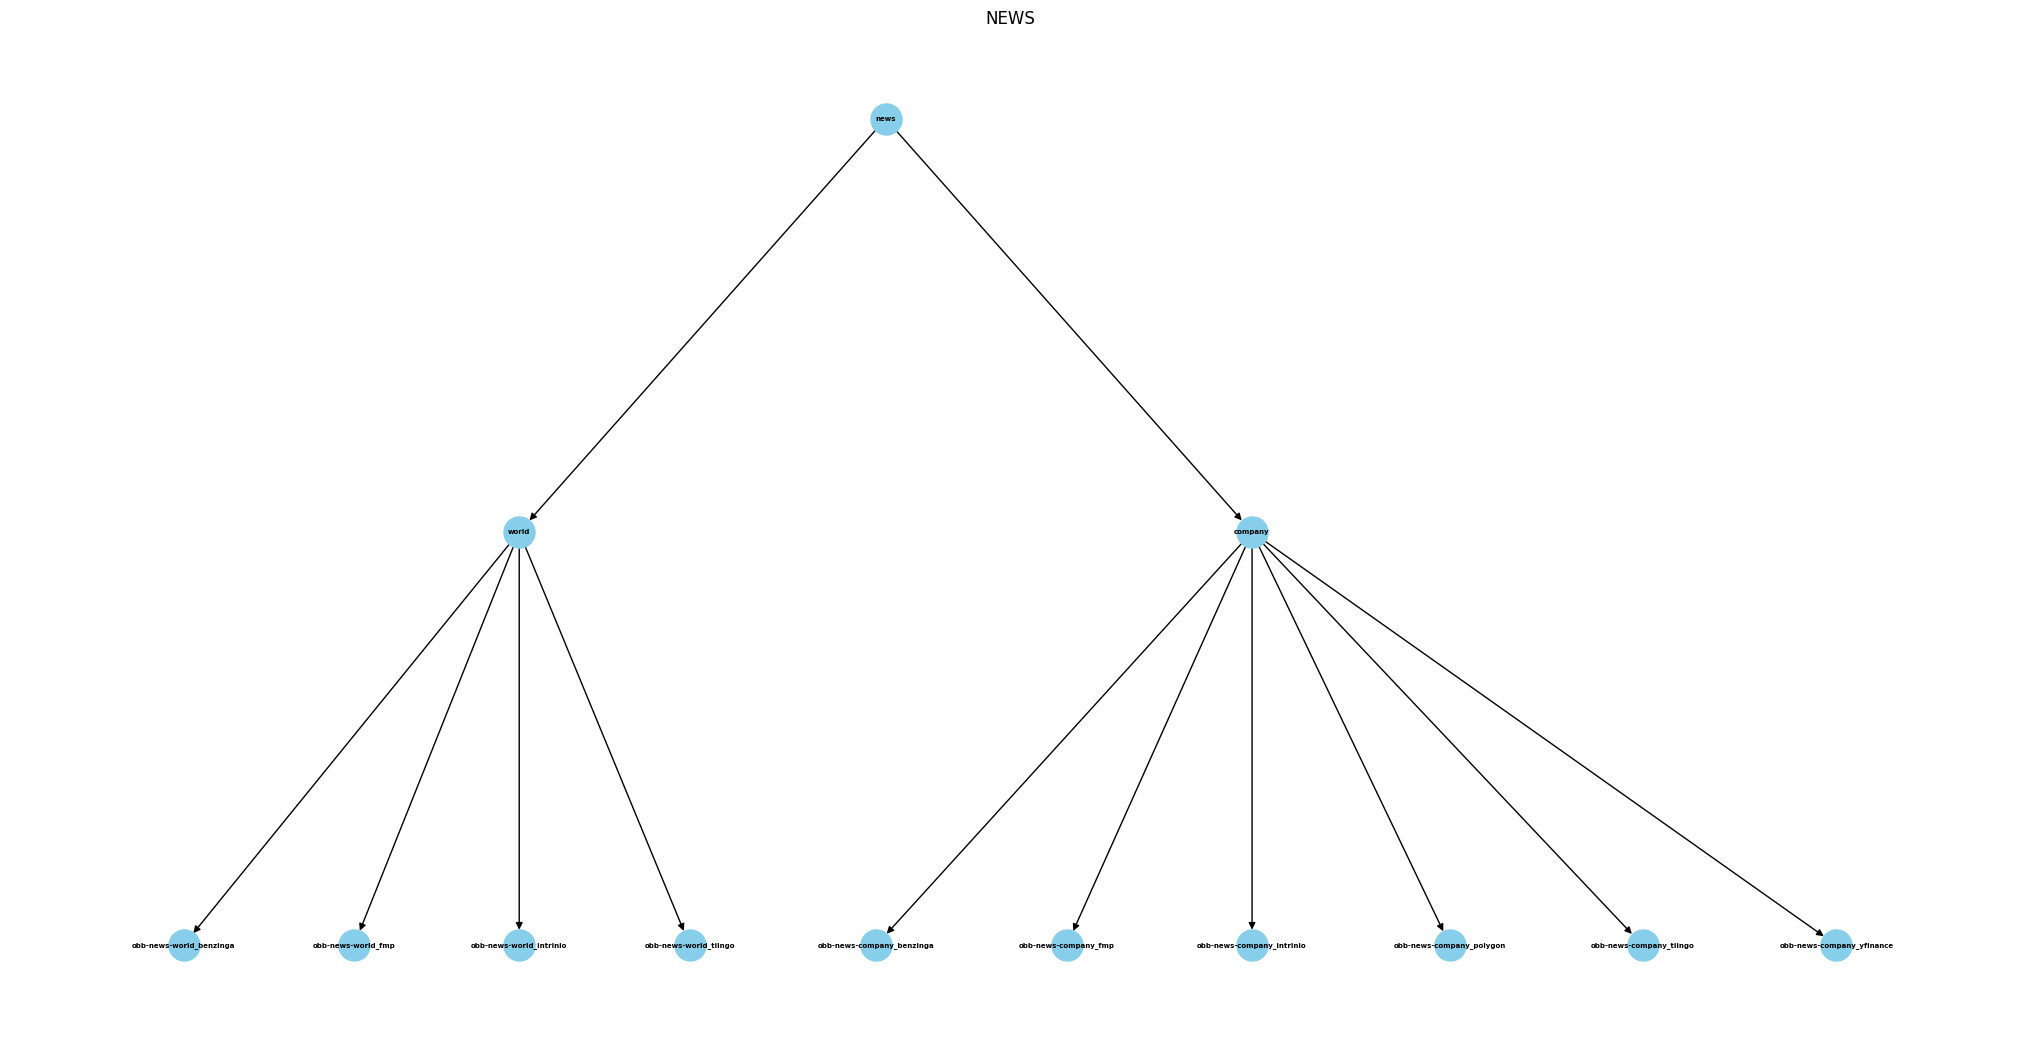

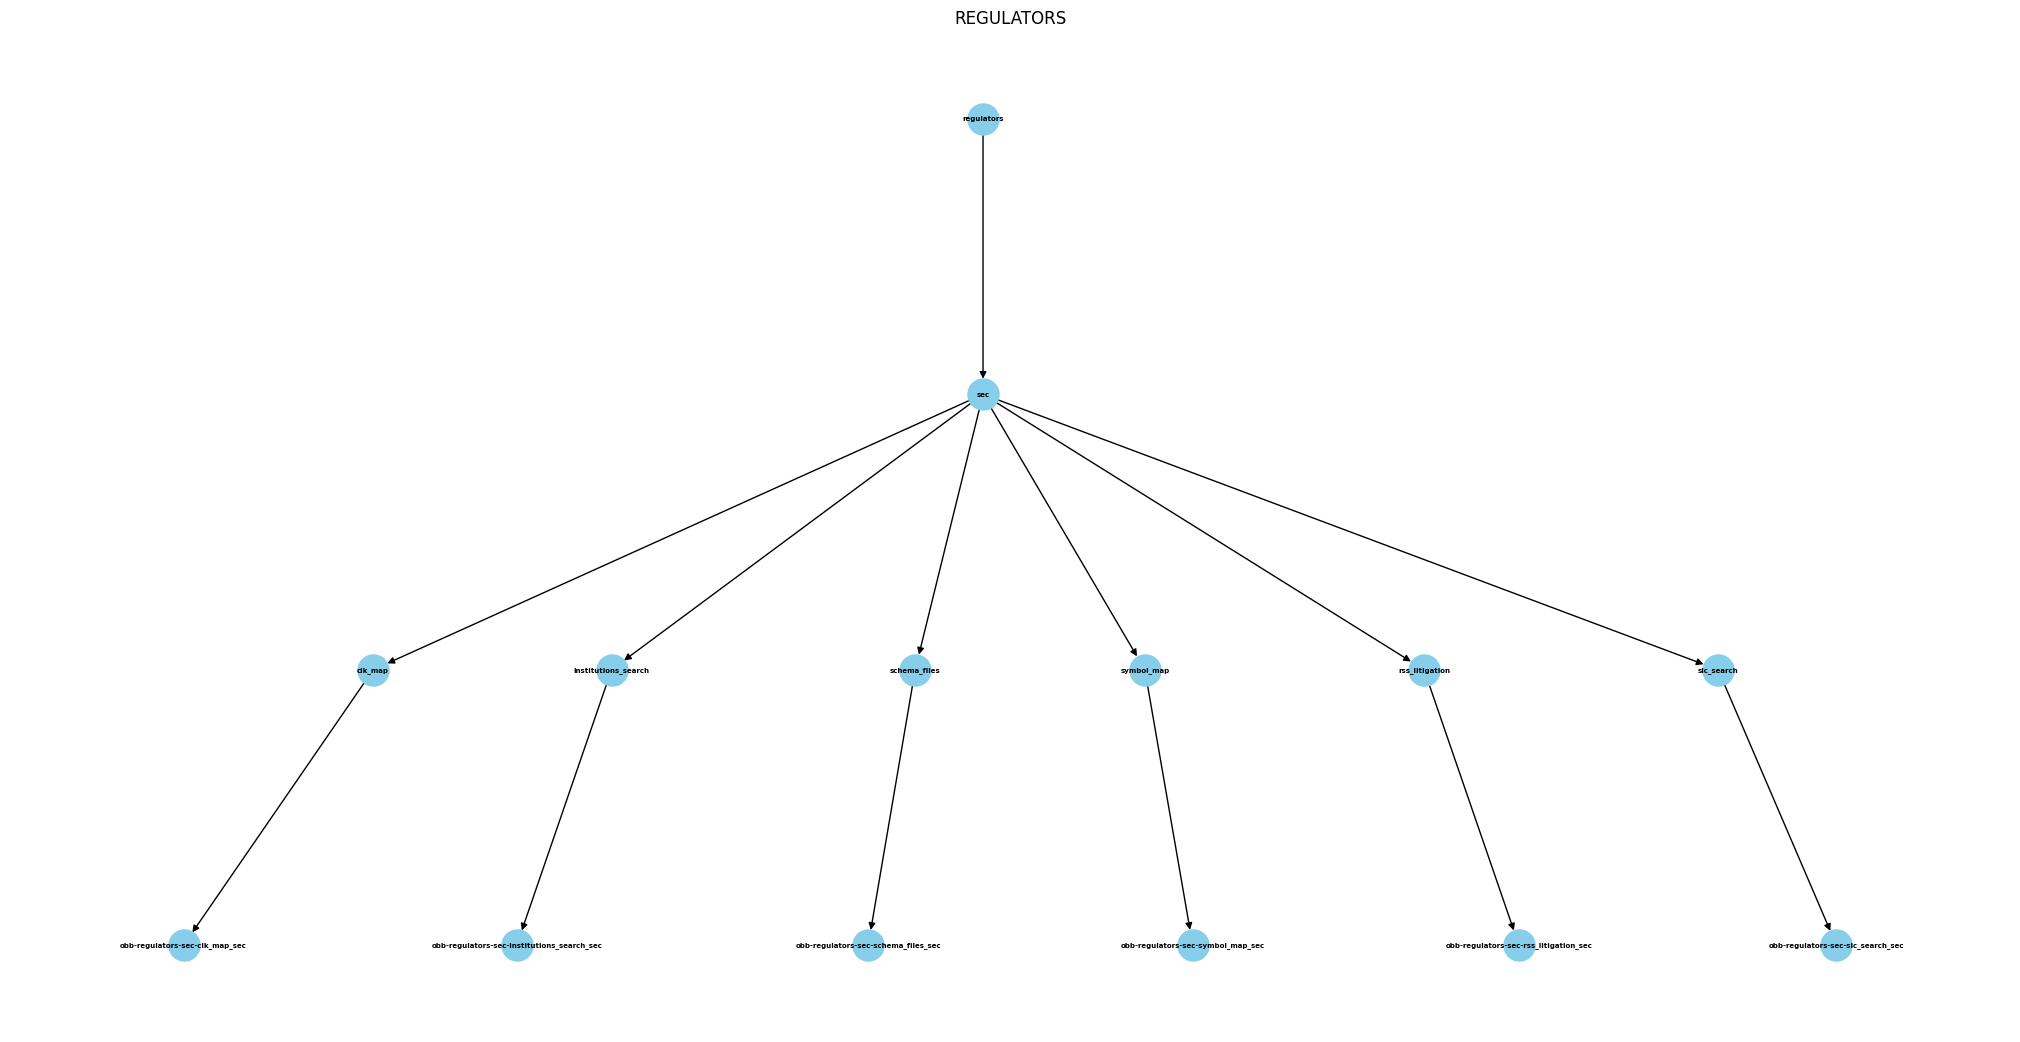

In [3]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import networkx as nx

for router in router_names:
    graph = router_names_graph[router]
    pos = graphviz_layout(graph, prog="dot")
    plt.figure(figsize=(20, 10))
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=5, font_weight="bold", arrows=True)
    plt.title(f"{router.upper()}")
    plt.show()

## TO BUILD THE DATABASE, UNCOMMENT THE BELOW LINES AND RUN THEM

In [ ]:
# from agent import build_docs_metadata

# docs,metadata = build_docs_metadata(router_names_graph)
# build_database(docs,metadata,os.environ['OPENAI_API_KEY'])

In [10]:
openbb_collection = load_database(os.environ['OPENAI_API_KEY'])
obb_chroma = OpenBBAgentChroma(openbb_collection) 
dspy_obb = DSPYOpenBBAgent(obb_chroma)

In [11]:
from openbb import obb
# Login to OpenBB and prefer dataframe outputs
obb.account.login(pat=os.environ['OBB_PAT'])

obb.user.preferences.output_type = "dataframe"

## IN THE BELOW EXAMPLE YOU CAN SEE HIERARCHICAL FUNCTION CALLING IN ACTION

1. First the parent levels equity, etf etc. are passed to LLM, and the LLM answers rightly that it needs equity node to answer this question.
2. Now, we will compare only the functions inside the equity node. After that there are multiple options like `screener`, `estimates` etc, and the LLM picks fundamental.
3. The graph iteratively builds to the right function and then we call it to get the results.

In [12]:
output = dspy_obb("Is tesla overvalued?")

print(output)

First level string: equity: Get historical and upcoming initial public offerings (IPOs). Get historical and upcoming dividend payments. Includes dividend amount, ex-dividend and payment dates. Get historical and upcoming stock split operations. Get historical and upcoming company earnings releases. Includes earnings per share (EPS) and revenue data. Get the closest peers for a given company.  Peers consist of companies trading on the same exchange, operating within the same sector and with comparable market capitalizations. Copmare reported company facts and fundamental data points. Get analyst price targets by company. Get historical analyst estimates for earnings and revenue. Get consensus price target and recommendation. Search for specific analysts and get their forecast track record. Get forward sales estimates. Get forward EBITDA estimates. Get forward EPS estimates. Get forward PE estimates. Get the top price gainers in the stock market. Get the top price losers in the stock mar

In [14]:
# Pass provider lists form OpenBB
PROVIDER_LIST = []

In [15]:
from typing import Optional
def function_calling_openbb(question:str)->Optional[str]:
    """This tool can be used to get financial data from the popular open-source platform OpenBB. 
       It takes a question and returns data by calling functions from OpenBB. OpenBB offers access to equity, options, crypto, forex, macro economy, fixed income, 
       and more while also offering a broad range of extensions to enhance the user experience according to their needs.

    Args:
        question (str): question to get information

    Returns:
        Optional[str]: It returns the data in markdown tables or None if no data is available
    """

    output = dspy_obb(question=question,provider_list=PROVIDER_LIST)
    return output

# AUTOGEN AGENT

In [33]:
from autogen import ConversableAgent
from autogen import register_function


llm_config = {"model":"gpt-4-turbo"}

system_message = "You have to respond to the question by building a plan first and then breakdown the plan into subquestions and use the function_calling_openbb tool to get financial data.\n" + \
                    "Make sure that you have plan well and ask relevant questions to the function_calling_openbb tool to get financial data. Also, restrict your question to one financial entity (like ticker) at one time.\n" + \
                    "For instance, if the user queries about the stock price quote of Apple and Microsoft, make sure to breakdown the it into subquestions stock price quote of Apple and stock price quote of Microsoft."


user_proxy = ConversableAgent(
    name = "Planner Admin",
    system_message=system_message,
    code_execution_config=False,
    llm_config=llm_config,
    human_input_mode="NEVER",
    is_termination_msg=lambda msg: "TERMINATE" in msg["content"],
)

tool_proxy = ConversableAgent(
  name="Tool Proxy",
  llm_config={"model":"gpt-3.5-turbo"},
  system_message="Check if the Planner Admin is querying the OpenBB tool properly, and provide feedback if necessary. Answer TERMINATE after you are done.",
  is_termination_msg=lambda msg: "exit" in msg.get("content",""),
  default_auto_reply="Use the function_calling_openbb tool to answer the question",
  human_input_mode="NEVER",
  )

register_function(
    function_calling_openbb,
    caller=user_proxy,
    executor=tool_proxy,
    name = "function_calling_openbb",
    description="Tool to query OpenBB documentation to get financial data."
)


In [27]:
input_text = "What is the price consensus of Google and Microsoft? Compare and contrast between them"

chat_result = user_proxy.initiate_chat(
        recipient=tool_proxy,
        message=input_text,
        max_turns=5
    )

Planner Admin (to Tool Proxy):

What is the price consensus of Google and Microsoft? Compare and contrast between them

--------------------------------------------------------------------------------
Tool Proxy (to Planner Admin):

Use the function_calling_openbb tool to answer the question

--------------------------------------------------------------------------------
Planner Admin (to Tool Proxy):

To effectively respond to your request about the price consensus of Google and Microsoft and their comparison, I will break down the task into two steps:

1. Retrieve the price consensus of Google.
2. Retrieve the price consensus of Microsoft.

Let me gather this information for you now using the necessary function calls.
***** Suggested tool call (call_0iglvkukS55IcLAIXRDq8luV): function_calling_openbb *****
Arguments: 
{"question": "price consensus of Google"}
****************************************************************************************
***** Suggested tool call (call_DOsGl

In [34]:
input_text = "What is the price consensus of Google and Microsoft? Compare and contrast between them"

chat_result = user_proxy.initiate_chat(
        recipient=tool_proxy,
        message=input_text,
        max_turns=5
    )

Planner Admin (to Tool Proxy):



What is the price consensus of Google and Microsoft? Compare and contrast between them

--------------------------------------------------------------------------------
Tool Proxy (to Planner Admin):

I'm sorry, but I am unable to provide real-time or up-to-date financial data including the current price consensus of Google and Microsoft. Would you like me to help you with any other information or analysis regarding these companies or any other topic?

--------------------------------------------------------------------------------
Planner Admin (to Tool Proxy):

To provide a comparison of the price consensus for Google and Microsoft, we will proceed as follows:

1. **Retrieve Google's (Alphabet Inc.) Price Consensus**: By querying the latest financial data available regardring Google's stock price consensus.
2. **Retrieve Microsoft's Price Consensus**: By querying the latest financial data available regarding Microsoft's stock price consensus.
3. **Compare the Data**: After retrieving

In [35]:
input_text = "How is the Gold futures market doing? Compare and contrast between Gold and Bitcoin?"

chat_result = user_proxy.initiate_chat(
        recipient=tool_proxy,
        message=input_text,
        max_turns=5
    )

Planner Admin (to Tool Proxy):

How is the Gold futures market doing? Compare and contrast between Gold and Bitcoin?

--------------------------------------------------------------------------------
Tool Proxy (to Planner Admin):

I'm sorry, but the request for information on the Gold futures market and a comparison between Gold and Bitcoin does not pertain to the OpenBB tool or its primary functionalities. The OpenBB tool is used to provide data and insights related to event planning, such as budget management, vendor coordination, and scheduling. 

If you have any specific event planning queries or require assistance with utilizing the OpenBB tool, please let me know so I can assist you further.

--------------------------------------------------------------------------------
Planner Admin (to Tool Proxy):

To respond to your query regarding the Gold futures market as well as the comparative analysis between Gold and Bitcoin, we can leverage the OpenBB tool to gather relevant financi